In [1]:
import cplex
from cplex.exceptions import CplexError
from docplex.mp.model import Model
import random
import matplotlib.pyplot as plt
import docplex.mp.model as Solution
import numpy as np

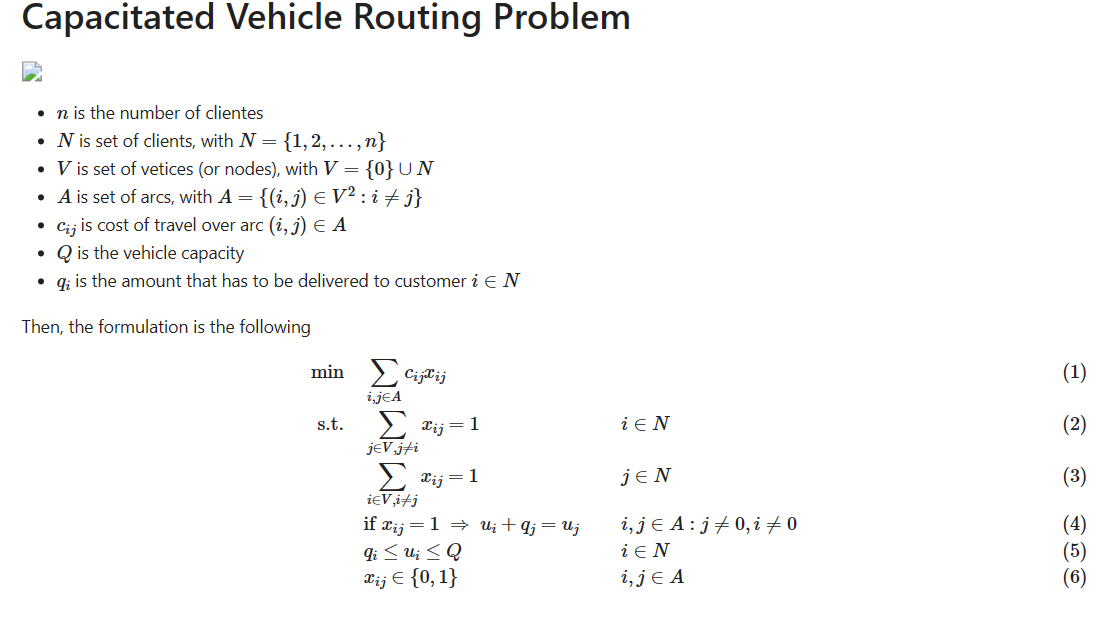

In [2]:
rnd = np.random
rnd.seed(0)

Khai báo các chỉ số cơ bản

In [3]:
n  = 14 #số lượng khách hàng
Q = 30 #sức chứa của xe
N = [i for i in range(1,n+1)] #set of client
V = [0] + N
q = {i:rnd.randint(1,14) for i in N}

In [4]:
loc_x = rnd.rand(len(V))*200
loc_y = rnd.rand(len(V))*100

In [5]:
A = [(i, j) for i in V for j in V if i != j]
c = {(i, j): np.hypot(loc_x[i]-loc_x[j], loc_y[i]-loc_y[j]) for i, j in A}
A

[(0, 1),
 (0, 2),
 (0, 3),
 (0, 4),
 (0, 5),
 (0, 6),
 (0, 7),
 (0, 8),
 (0, 9),
 (0, 10),
 (0, 11),
 (0, 12),
 (0, 13),
 (0, 14),
 (1, 0),
 (1, 2),
 (1, 3),
 (1, 4),
 (1, 5),
 (1, 6),
 (1, 7),
 (1, 8),
 (1, 9),
 (1, 10),
 (1, 11),
 (1, 12),
 (1, 13),
 (1, 14),
 (2, 0),
 (2, 1),
 (2, 3),
 (2, 4),
 (2, 5),
 (2, 6),
 (2, 7),
 (2, 8),
 (2, 9),
 (2, 10),
 (2, 11),
 (2, 12),
 (2, 13),
 (2, 14),
 (3, 0),
 (3, 1),
 (3, 2),
 (3, 4),
 (3, 5),
 (3, 6),
 (3, 7),
 (3, 8),
 (3, 9),
 (3, 10),
 (3, 11),
 (3, 12),
 (3, 13),
 (3, 14),
 (4, 0),
 (4, 1),
 (4, 2),
 (4, 3),
 (4, 5),
 (4, 6),
 (4, 7),
 (4, 8),
 (4, 9),
 (4, 10),
 (4, 11),
 (4, 12),
 (4, 13),
 (4, 14),
 (5, 0),
 (5, 1),
 (5, 2),
 (5, 3),
 (5, 4),
 (5, 6),
 (5, 7),
 (5, 8),
 (5, 9),
 (5, 10),
 (5, 11),
 (5, 12),
 (5, 13),
 (5, 14),
 (6, 0),
 (6, 1),
 (6, 2),
 (6, 3),
 (6, 4),
 (6, 5),
 (6, 7),
 (6, 8),
 (6, 9),
 (6, 10),
 (6, 11),
 (6, 12),
 (6, 13),
 (6, 14),
 (7, 0),
 (7, 1),
 (7, 2),
 (7, 3),
 (7, 4),
 (7, 5),
 (7, 6),
 (7, 8),
 (7, 9),
 (

In [6]:
mdl = Model('CVRP')

In [7]:
x = mdl.binary_var_dict(A, name='x')
u = mdl.continuous_var_dict(N, ub=Q, name='u')

In [8]:
mdl.minimize(mdl.sum(c[i,j] * x [i,j] for i,j in A))

In [9]:
mdl.minimize(mdl.sum(c[i, j]*x[i, j] for i, j in A))
mdl.add_constraints(mdl.sum(x[i, j] for j in V if j != i) == 1 for i in N)
mdl.add_constraints(mdl.sum(x[i, j] for i in V if i != j) == 1 for j in N)
mdl.add_indicator_constraints(mdl.indicator_constraint(x[i, j], u[i]+q[j] == u[j]) for i, j in A if i != 0 and j != 0)
mdl.add_constraints(u[i] >= q[i] for i in N)
solution = mdl.solve(log_output=True)


Version identifier: 22.1.1.0 | 2022-11-27 | 9160aff4d
CPXPARAM_Read_DataCheck                          1
Found incumbent of value 2955.552169 after 0.00 sec. (0.02 ticks)
Tried aggregator 2 times.
MIP Presolve eliminated 14 rows and 0 columns.
MIP Presolve modified 91 coefficients.
Aggregator did 91 substitutions.
Reduced MIP has 119 rows, 315 columns, and 665 nonzeros.
Reduced MIP has 210 binaries, 0 generals, 0 SOSs, and 182 indicators.
Presolve time = 0.02 sec. (0.72 ticks)
Probing time = 0.00 sec. (0.89 ticks)
Tried aggregator 1 time.
Detecting symmetries...
Reduced MIP has 119 rows, 315 columns, and 665 nonzeros.
Reduced MIP has 210 binaries, 0 generals, 0 SOSs, and 182 indicators.
Presolve time = 0.00 sec. (0.46 ticks)
Probing time = 0.02 sec. (0.85 ticks)
Clique table members: 119.
MIP emphasis: balance optimality and feasibility.
MIP search method: dynamic search.
Parallel mode: deterministic, using up to 12 threads.
Root relaxation solution time = 0.00 sec. (0.23 ticks)

     

Detecting symmetries...
      0     2      412.6821    14      995.1432      412.6821       66   58.53%
Elapsed time = 0.09 sec. (14.41 ticks, tree = 0.02 MB, solutions = 3)
*  1144+  557                          963.6626      422.2135            56.19%
*  1159+  557                          949.7304      422.2135            55.54%

Performing restart 1

Repeating presolve.
Tried aggregator 1 time.
Reduced MIP has 119 rows, 315 columns, and 665 nonzeros.
Reduced MIP has 210 binaries, 0 generals, 0 SOSs, and 182 indicators.
Presolve time = 0.00 sec. (0.32 ticks)
Tried aggregator 1 time.
Reduced MIP has 119 rows, 315 columns, and 665 nonzeros.
Reduced MIP has 210 binaries, 0 generals, 0 SOSs, and 182 indicators.
Presolve time = 0.01 sec. (0.49 ticks)
Represolve time = 0.01 sec. (2.59 ticks)
   4891     0      412.6821    28      949.7304      Cuts: 13    38270   53.35%
  12309  4078      842.7602     9      949.7304      447.0200    89173   52.93%
* 17758  6340      integral     0      9

 51089422 3915904        cutoff            882.7908      811.9341 4.16e+08    8.03%


In [ ]:
solution.display()

solution for: CVRP
objective: 1135.336
status: OPTIMAL_SOLUTION(2)
x_0_1 = 1
x_0_2 = 1
x_0_3 = 1
x_0_5 = 1
x_0_7 = 1
x_0_10 = 1
x_1_0 = 1
x_2_9 = 1
x_3_6 = 1
x_4_0 = 1
x_5_0 = 1
x_6_0 = 1
x_7_8 = 1
x_8_0 = 1
x_9_4 = 1
x_10_0 = 1
u_1 = 10.000
u_2 = 1.000
u_3 = 4.000
u_4 = 10.000
u_5 = 10.000
u_6 = 8.000
u_7 = 6.000
u_8 = 9.000
u_9 = 6.000
u_10 = 10.000


In [ ]:
active_arcs = [a for a in A if x[a].solution_value > 0.9]
active_arcs

[(0, 1),
 (0, 2),
 (0, 3),
 (0, 5),
 (0, 7),
 (0, 10),
 (1, 0),
 (2, 9),
 (3, 6),
 (4, 0),
 (5, 0),
 (6, 0),
 (7, 8),
 (8, 0),
 (9, 4),
 (10, 0)]

In [ ]:
def find_all_routes(data_list):
    routes = []
    pre_value = -1
    current_route = []
    while True:
        if len(data_list) == 0:
            break
        for i in data_list:
            if pre_value == 0:
                routes.append(current_route.copy())
                current_route.clear()
                pre_value = -1
                break
            if i[0] == 0 and len(current_route) == 0:
                current_route.extend([i[0], i[1]])
                pre_value = i[1]
                data_list.remove(i)
                continue
            elif i[0] == pre_value:
                current_route.append(i[1])
                pre_value = i[1]
                data_list.remove(i)
                if len(data_list) == 0:
                    routes.append(current_route)
                    break
                continue
    return routes

In [ ]:
def format_route(route):
    return " -> ".join(str(node) for node in route)

In [ ]:
result_routes = find_all_routes(active_arcs)
for i, route in enumerate(result_routes, 1):
    print(f"Route {i}: {format_route(route)}")


Route 1: 0 -> 1 -> 0
Route 2: 0 -> 2 -> 9 -> 4 -> 0
Route 3: 0 -> 3 -> 6 -> 0
Route 4: 0 -> 5 -> 0
Route 5: 0 -> 7 -> 8 -> 0
Route 6: 0 -> 10 -> 0
